PPCA lavora con più variabili osservabili anzichè una sola

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import aesara.tensor as at
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score
from scipy import stats

In [2]:
scaler = StandardScaler()

In [3]:
data = np.load('prova.npy', allow_pickle=True).item()

In [4]:
data.keys()

dict_keys(['hr', 'eda', 'pupil'])

prendo un'implementazione di sppca e la applico al nostro caso

different types of observable data

1) gaze
2) fisio
    2.1) heart rate variabilty
    2.2) eda phasic value
3) social anxiety
4) aspettativa del dolore

gaze =

In [5]:
gaze = data['pupil']
hr = data['hr']
eda = data['eda']
'''social_anx = data['social anxiety'][:,np.newaxis]
pain_exp = data['pain expectation'][:,np.newaxis]'''


N_gaze = gaze.shape[0]
D_gaze = gaze.shape[1]

N_hr = hr.shape[0]
D_hr = hr.shape[1]

N_eda = eda.shape[0]
D_eda = eda.shape[1]
K = 1


In [6]:
print(D_gaze, D_eda, D_hr)

5 6 6


In [15]:
with pm.Model() as sPPCA:
    #dati osservabili
    gaze_data = pm.MutableData("gaze_data", gaze.T)
    hr_data = pm.MutableData("hr_data", hr.T)
    #eda_data = pm.MutableData("eda_data", eda.T)

    #matrici pesi
    Wgaze = pm.Normal('Wgaze', mu=at.zeros([D_gaze, K]), sigma=2.0 * at.ones([D_gaze, K]), shape=[D_gaze, K])
    Whr = pm.Normal('Whr', mu=at.zeros([D_hr, K]), sigma=2.0 * at.ones([D_hr, K]), shape=[D_hr, K])
    #Weda = pm.Normal('Weda', mu=at.zeros([D_eda, K]), sigma=2.0 * at.ones([D_eda, K]), shape=[D_eda, K])

    #latent space
    c = pm.Normal('c', mu=at.zeros([N_gaze, K]), sigma=at.ones([N_gaze, K]), shape=[N_gaze, K])

    x_gaze = pm.Normal('x_gaze', mu=Wgaze.dot(c.T), sigma=at.ones([D_gaze, N_gaze]), shape=[D_gaze, N_gaze], observed=gaze_data)
    x_hr = pm.Bernoulli('x_hr', p=pm.math.sigmoid(Whr.dot(c.T)), shape=[D_hr, N_hr], observed=hr_data)
    #x_eda = pm.Bernoulli('x_eda', p=pm.math.sigmoid(Weda.dot(c.T)), shape=[D_eda, N_eda], observed=eda_data)

In [16]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [17]:
'''gv = pm.model_to_graphviz(sPPCA)
gv.view()'''

'gv = pm.model_to_graphviz(sPPCA)\ngv.view()'

In [18]:
sPPCA.free_RVs

[Wgaze ~ N(f(), f()), Whr ~ N(f(), f()), c ~ N(f(), f())]

In [19]:
with sPPCA:
    trace = pm.sample(init='advi+adapt_diag', chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 23200
Interrupted at 23,199 [11%]: Average Loss = 1,799.5
Sequential sampling (1 chains in 1 job)
NUTS: [Wgaze, Whr, c]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 9 seconds.


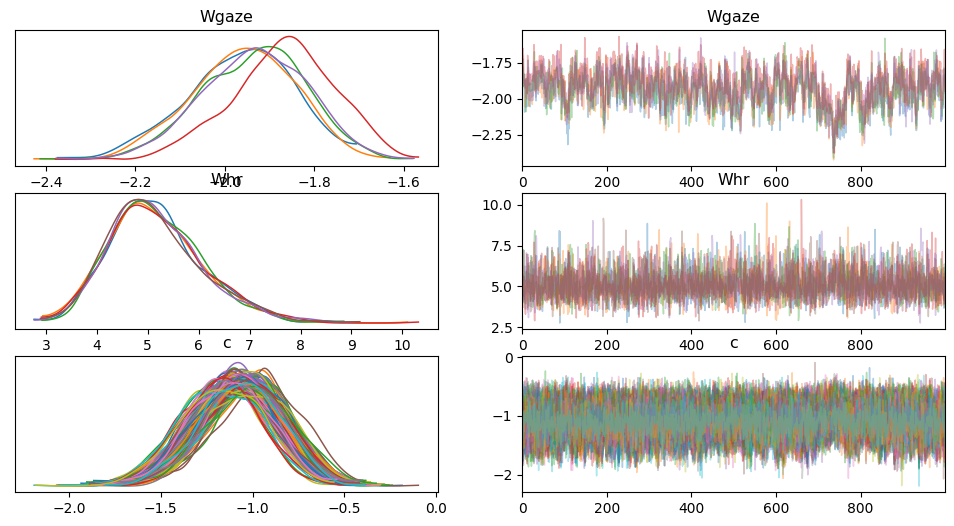

In [20]:
#az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen")
az.plot_trace(trace);
plt.show()

In [ ]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"x_data": X})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["hr", "eda"], random_seed=123)
    hr_pred = posterior_predictive["hr"]
    eda_pred = posterior_predictive["eda"]

In [ ]:
hr_pred_mode = np.squeeze(stats.mode(hr_pred)[0])[:,np.newaxis]
eda_pred_mode = np.squeeze(stats.mode(eda_pred)[0])[:,np.newaxis]

In [ ]:
train_accuracy_hr = accuracy_score(hr, hr_pred_mode)
train_accuracy_eda = accuracy_score(eda, eda_pred_mode)
print('\n\tAccuracy hr: ' + str(train_accuracy_hr))
print('\tAccuracy eda: ' + str(train_accuracy_eda))
print(' ')

In [ ]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"hr_data": hr, "eda_data": eda})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["gaze"], random_seed=123)
    gaze_pred = posterior_predictive["gaze"]

In [ ]:
gaze_pred_mean = np.mean(gaze_pred, axis=0).T.reshape(-1)
gaze_true = gaze.reshape(-1)
reconstructed_r2 = r2_score(gaze_true, gaze_pred_mean)

print('\n\tReconstructed X R2 score: ' + str(reconstructed_r2))